In [ ]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [2]:
import pandas as pd
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns

In [4]:
# loading data from csv files
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")
train_df = pd.read_csv("train.csv")

In [ ]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
fake_df['label'] = 1
true_df['label'] = 0

In [6]:
combine_df = pd.concat([fake_df,true_df])
combine_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
combine_df = combine_df.drop(["subject","date"],axis=1)
train_df = train_df.drop(["id","author"],axis=1)

In [8]:
full_df = pd.concat([combine_df,train_df])
full_df["full_text"] = full_df["title"].combine_first(full_df["text"])
full_df = full_df.drop(["text","title"],axis=1)
full_df.head()

,label,full_text
0,1,Donald Trump Sends Out Embarrassing New Year’...
1,1,Drunk Bragging Trump Staffer Started Russian ...
2,1,Sheriff David Clarke Becomes An Internet Joke...
3,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,1,Pope Francis Just Called Out Donald Trump Dur...


In [9]:
full_df = full_df.reset_index()

In [10]:
full_df = full_df.drop(["index"],axis=1)

In [11]:
full_df.head()

,label,full_text
0,1,Donald Trump Sends Out Embarrassing New Year’...
1,1,Drunk Bragging Trump Staffer Started Russian ...
2,1,Sheriff David Clarke Becomes An Internet Joke...
3,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,1,Pope Francis Just Called Out Donald Trump Dur...


## expoloring the dataset
1 means unreliable and
0 means reliable

In [12]:
full_df["label"].value_counts()

1    33894
0    31804
Name: label, dtype: int64

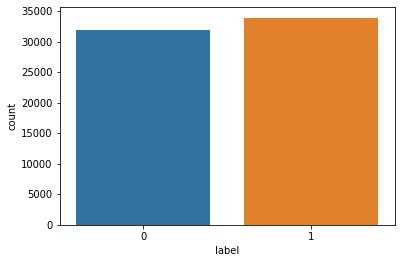

In [13]:
sns.countplot(full_df["label"])

# Tokenization

In [14]:
def tokeniz(text):
    token = re.split('\W+', text)
    return token

full_df["token_text"] = full_df["full_text"].apply(lambda x:tokeniz(x.lower()))
full_df.head()

,label,full_text,token_text
0,1,Donald Trump Sends Out Embarrassing New Year’...,"[, donald, trump, sends, out, embarrassing, ne..."
1,1,Drunk Bragging Trump Staffer Started Russian ...,"[, drunk, bragging, trump, staffer, started, r..."
2,1,Sheriff David Clarke Becomes An Internet Joke...,"[, sheriff, david, clarke, becomes, an, intern..."
3,1,Trump Is So Obsessed He Even Has Obama’s Name...,"[, trump, is, so, obsessed, he, even, has, oba..."
4,1,Pope Francis Just Called Out Donald Trump Dur...,"[, pope, francis, just, called, out, donald, t..."


# Remove stopwords

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stopword = nltk.corpus.stopwords.words('english')

In [17]:
def remove_stopword(token):
    text = [word for word in token if word not in stopword]
    return text

full_df["nostopword_text"] = full_df["token_text"].apply(lambda x:remove_stopword(x))

full_df.head()

,label,full_text,token_text,nostopword_text
0,1,Donald Trump Sends Out Embarrassing New Year’...,"[, donald, trump, sends, out, embarrassing, ne...","[, donald, trump, sends, embarrassing, new, ye..."
1,1,Drunk Bragging Trump Staffer Started Russian ...,"[, drunk, bragging, trump, staffer, started, r...","[, drunk, bragging, trump, staffer, started, r..."
2,1,Sheriff David Clarke Becomes An Internet Joke...,"[, sheriff, david, clarke, becomes, an, intern...","[, sheriff, david, clarke, becomes, internet, ..."
3,1,Trump Is So Obsessed He Even Has Obama’s Name...,"[, trump, is, so, obsessed, he, even, has, oba...","[, trump, obsessed, even, obama, name, coded, ..."
4,1,Pope Francis Just Called Out Donald Trump Dur...,"[, pope, francis, just, called, out, donald, t...","[, pope, francis, called, donald, trump, chris..."


# Lemmatizing

In [18]:
wl = WordNetLemmatizer()

In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [21]:
def lemmatizing(stopword):
    text = [wl.lemmatize(word) for word in stopword]
    return text

full_df["lemmatizing_text"] = full_df["nostopword_text"].apply(lambda x:lemmatizing(x))

full_df.head()

,label,full_text,token_text,nostopword_text,lemmatizing_text
0,1,Donald Trump Sends Out Embarrassing New Year’...,"[, donald, trump, sends, out, embarrassing, ne...","[, donald, trump, sends, embarrassing, new, ye...","[, donald, trump, sends, embarrassing, new, ye..."
1,1,Drunk Bragging Trump Staffer Started Russian ...,"[, drunk, bragging, trump, staffer, started, r...","[, drunk, bragging, trump, staffer, started, r...","[, drunk, bragging, trump, staffer, started, r..."
2,1,Sheriff David Clarke Becomes An Internet Joke...,"[, sheriff, david, clarke, becomes, an, intern...","[, sheriff, david, clarke, becomes, internet, ...","[, sheriff, david, clarke, becomes, internet, ..."
3,1,Trump Is So Obsessed He Even Has Obama’s Name...,"[, trump, is, so, obsessed, he, even, has, oba...","[, trump, obsessed, even, obama, name, coded, ...","[, trump, obsessed, even, obama, name, coded, ..."
4,1,Pope Francis Just Called Out Donald Trump Dur...,"[, pope, francis, just, called, out, donald, t...","[, pope, francis, called, donald, trump, chris...","[, pope, francis, called, donald, trump, chris..."


In [22]:
full_df["lemmatizing_text2"] = [" ".join(x) for x in list(full_df["lemmatizing_text"])]

In [23]:
full_df["lemmatizing_text2"].head()

0     donald trump sends embarrassing new year eve ...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes internet joke th...
3     trump obsessed even obama name coded website ...
4     pope francis called donald trump christmas sp...
Name: lemmatizing_text2, dtype: object

In [25]:
# full_df.to_csv("data/clean_data.csv")

# N-Grams

In [26]:
fake = full_df[(full_df["label"] == 1)]
true = full_df[(full_df["label"] == 0)]

In [27]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [28]:
def basic_clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords= nltk.corpus.stopwords.words('english')
    words = re.split('\W+', text)
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [29]:
true_word = basic_clean(''.join(str(true['full_text'].tolist())))

In [30]:
true_bigrams = (pd.Series(nltk.ngrams(true_word, 2)).value_counts())[:20]

In [31]:
bigram_t = pd.DataFrame(true_bigrams).reset_index()
bigram_t = bigram_t.rename(columns={"index":"trueBigram",0:"count"})
bigram_t

,trueBigram,count
0,"(New, York)",6459
1,"(York, Times)",6266
2,"(The, New)",6234
3,"(U, S)",4589
4,"(White, House)",916
5,"(North, Korea)",768
6,"(Donald, Trump)",673
7,"(U, N)",544
8,"(Trump, say)",365
9,"(Islamic, State)",306


In [32]:
true_trigrams = (pd.Series(nltk.ngrams(true_word, 3)).value_counts())[:20]
trigram_t = pd.DataFrame(true_trigrams).reset_index()
trigram_t = trigram_t.rename(columns={"index":"trueTrigram",0:"count"})
trigram_t

,trueTrigram,count
0,"(New, York, Times)",6266
1,"(The, New, York)",6227
2,"(York, Times, Trump)",234
3,"(Briefing, The, New)",203
4,"(say, U, S)",176
5,"(U, S, House)",163
6,"(York, Times, Donald)",163
7,"(Times, Donald, Trump)",162
8,"(U, S, Senate)",154
9,"(York, Times, The)",153


In [33]:
fake_word = basic_clean(''.join(str(fake['full_text'].tolist())))

In [34]:
fake_bigrams = (pd.Series(nltk.ngrams(fake_word, 2)).value_counts())[:20]

In [35]:
fake_trigrams = (pd.Series(nltk.ngrams(fake_word, 3)).value_counts())[:20]

In [36]:
bigram_f = pd.DataFrame(fake_bigrams).reset_index()
bigram_f = bigram_f.rename(columns={"index":"fakeBigram",0:"count"})
bigram_f

,fakeBigram,count
0,"(Donald, Trump)",963
1,"(U, S)",667
2,"(Hillary, Clinton)",644
3,"(President, Trump)",366
4,"(White, House)",359
5,"(In, The)",324
6,"(Of, The)",314
7,"(VIDEO, WATCH)",307
8,"(VIDEO, Trump)",291
9,"(Trump, Is)",284


In [37]:
trigram_f = pd.DataFrame(fake_trigrams).reset_index()
trigram_f = trigram_f.rename(columns={"index":"fakeTrigram",0:"count"})
trigram_f

,fakeTrigram,count
0,"(Black, Lives, Matter)",131
1,"(Boiler, Room, EP)",104
2,"(The, White, House)",80
3,"(America, Finest, News)",79
4,"(Onion, America, Finest)",79
5,"(Finest, News, Source)",79
6,"(The, Onion, America)",79
7,"(You, Won, Believe)",57
8,"(World, War, 3)",57
9,"(Bill, O, Reilly)",53


# WordCloud

In [38]:
def plot_wordcloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
#     plt.savefig(f'data/image/{text}.png')

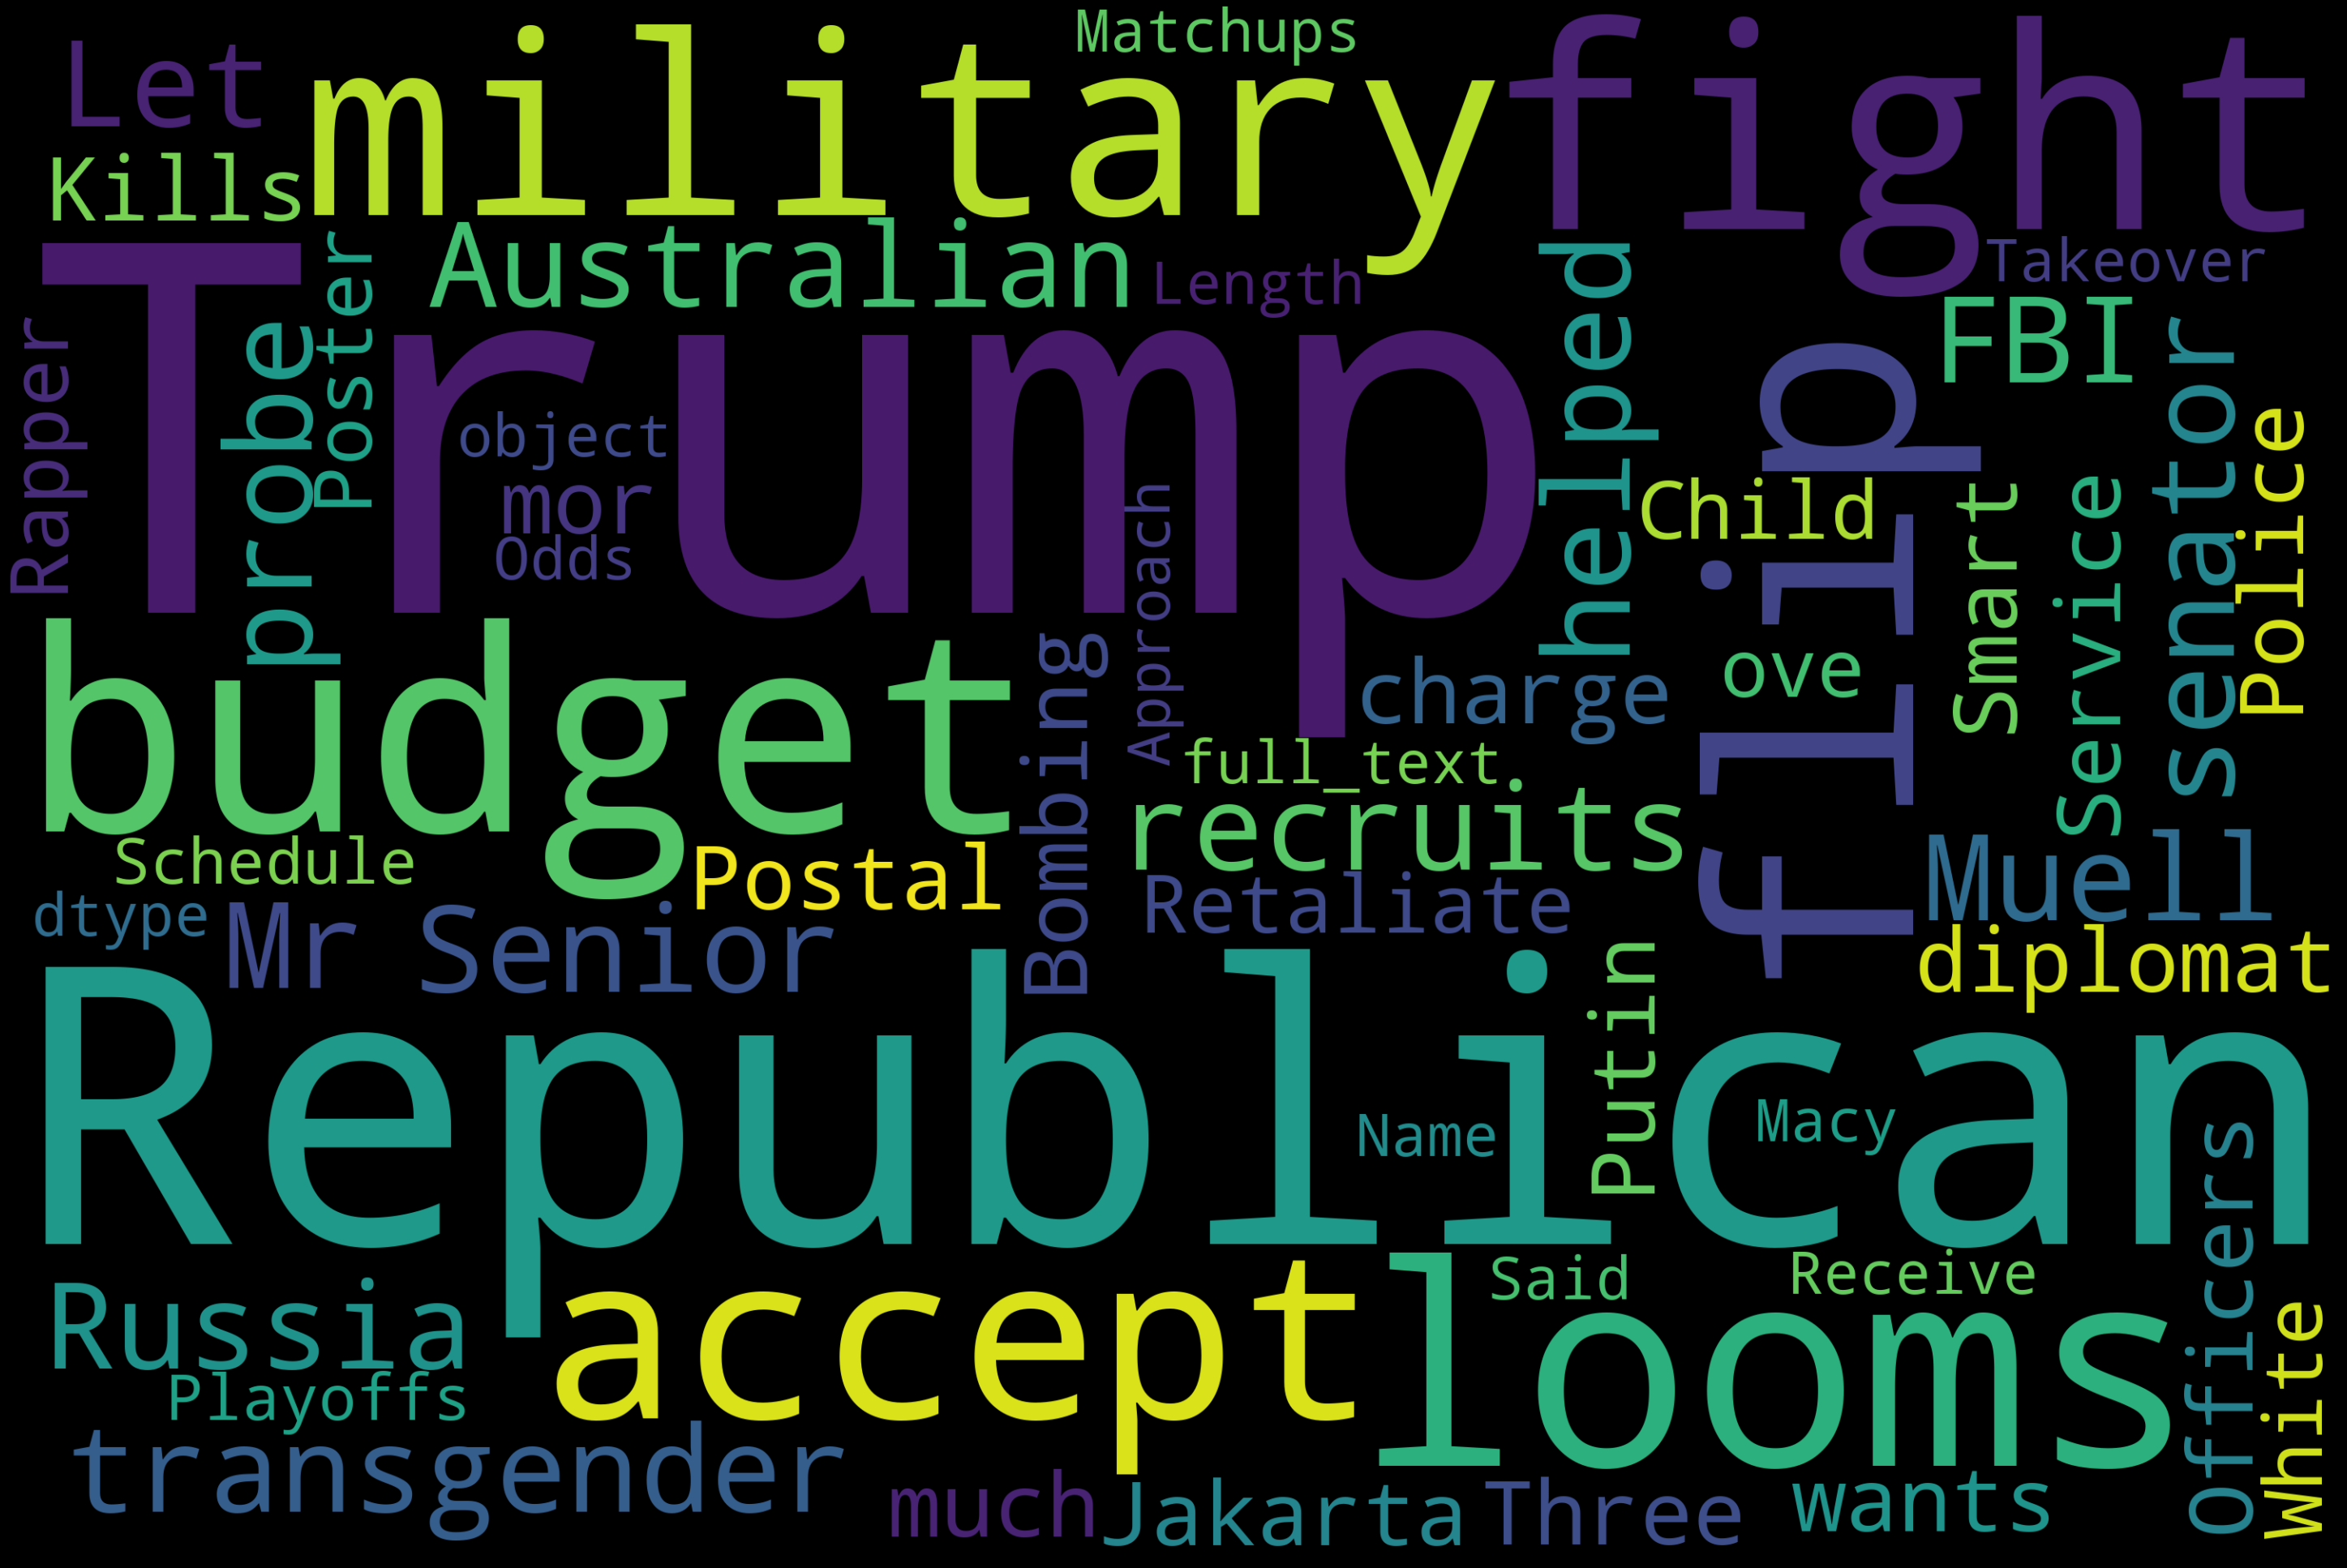

In [39]:
plot_wordcloud(true["full_text"])
# plt.savefig("data/image/true_wordcloud.png")

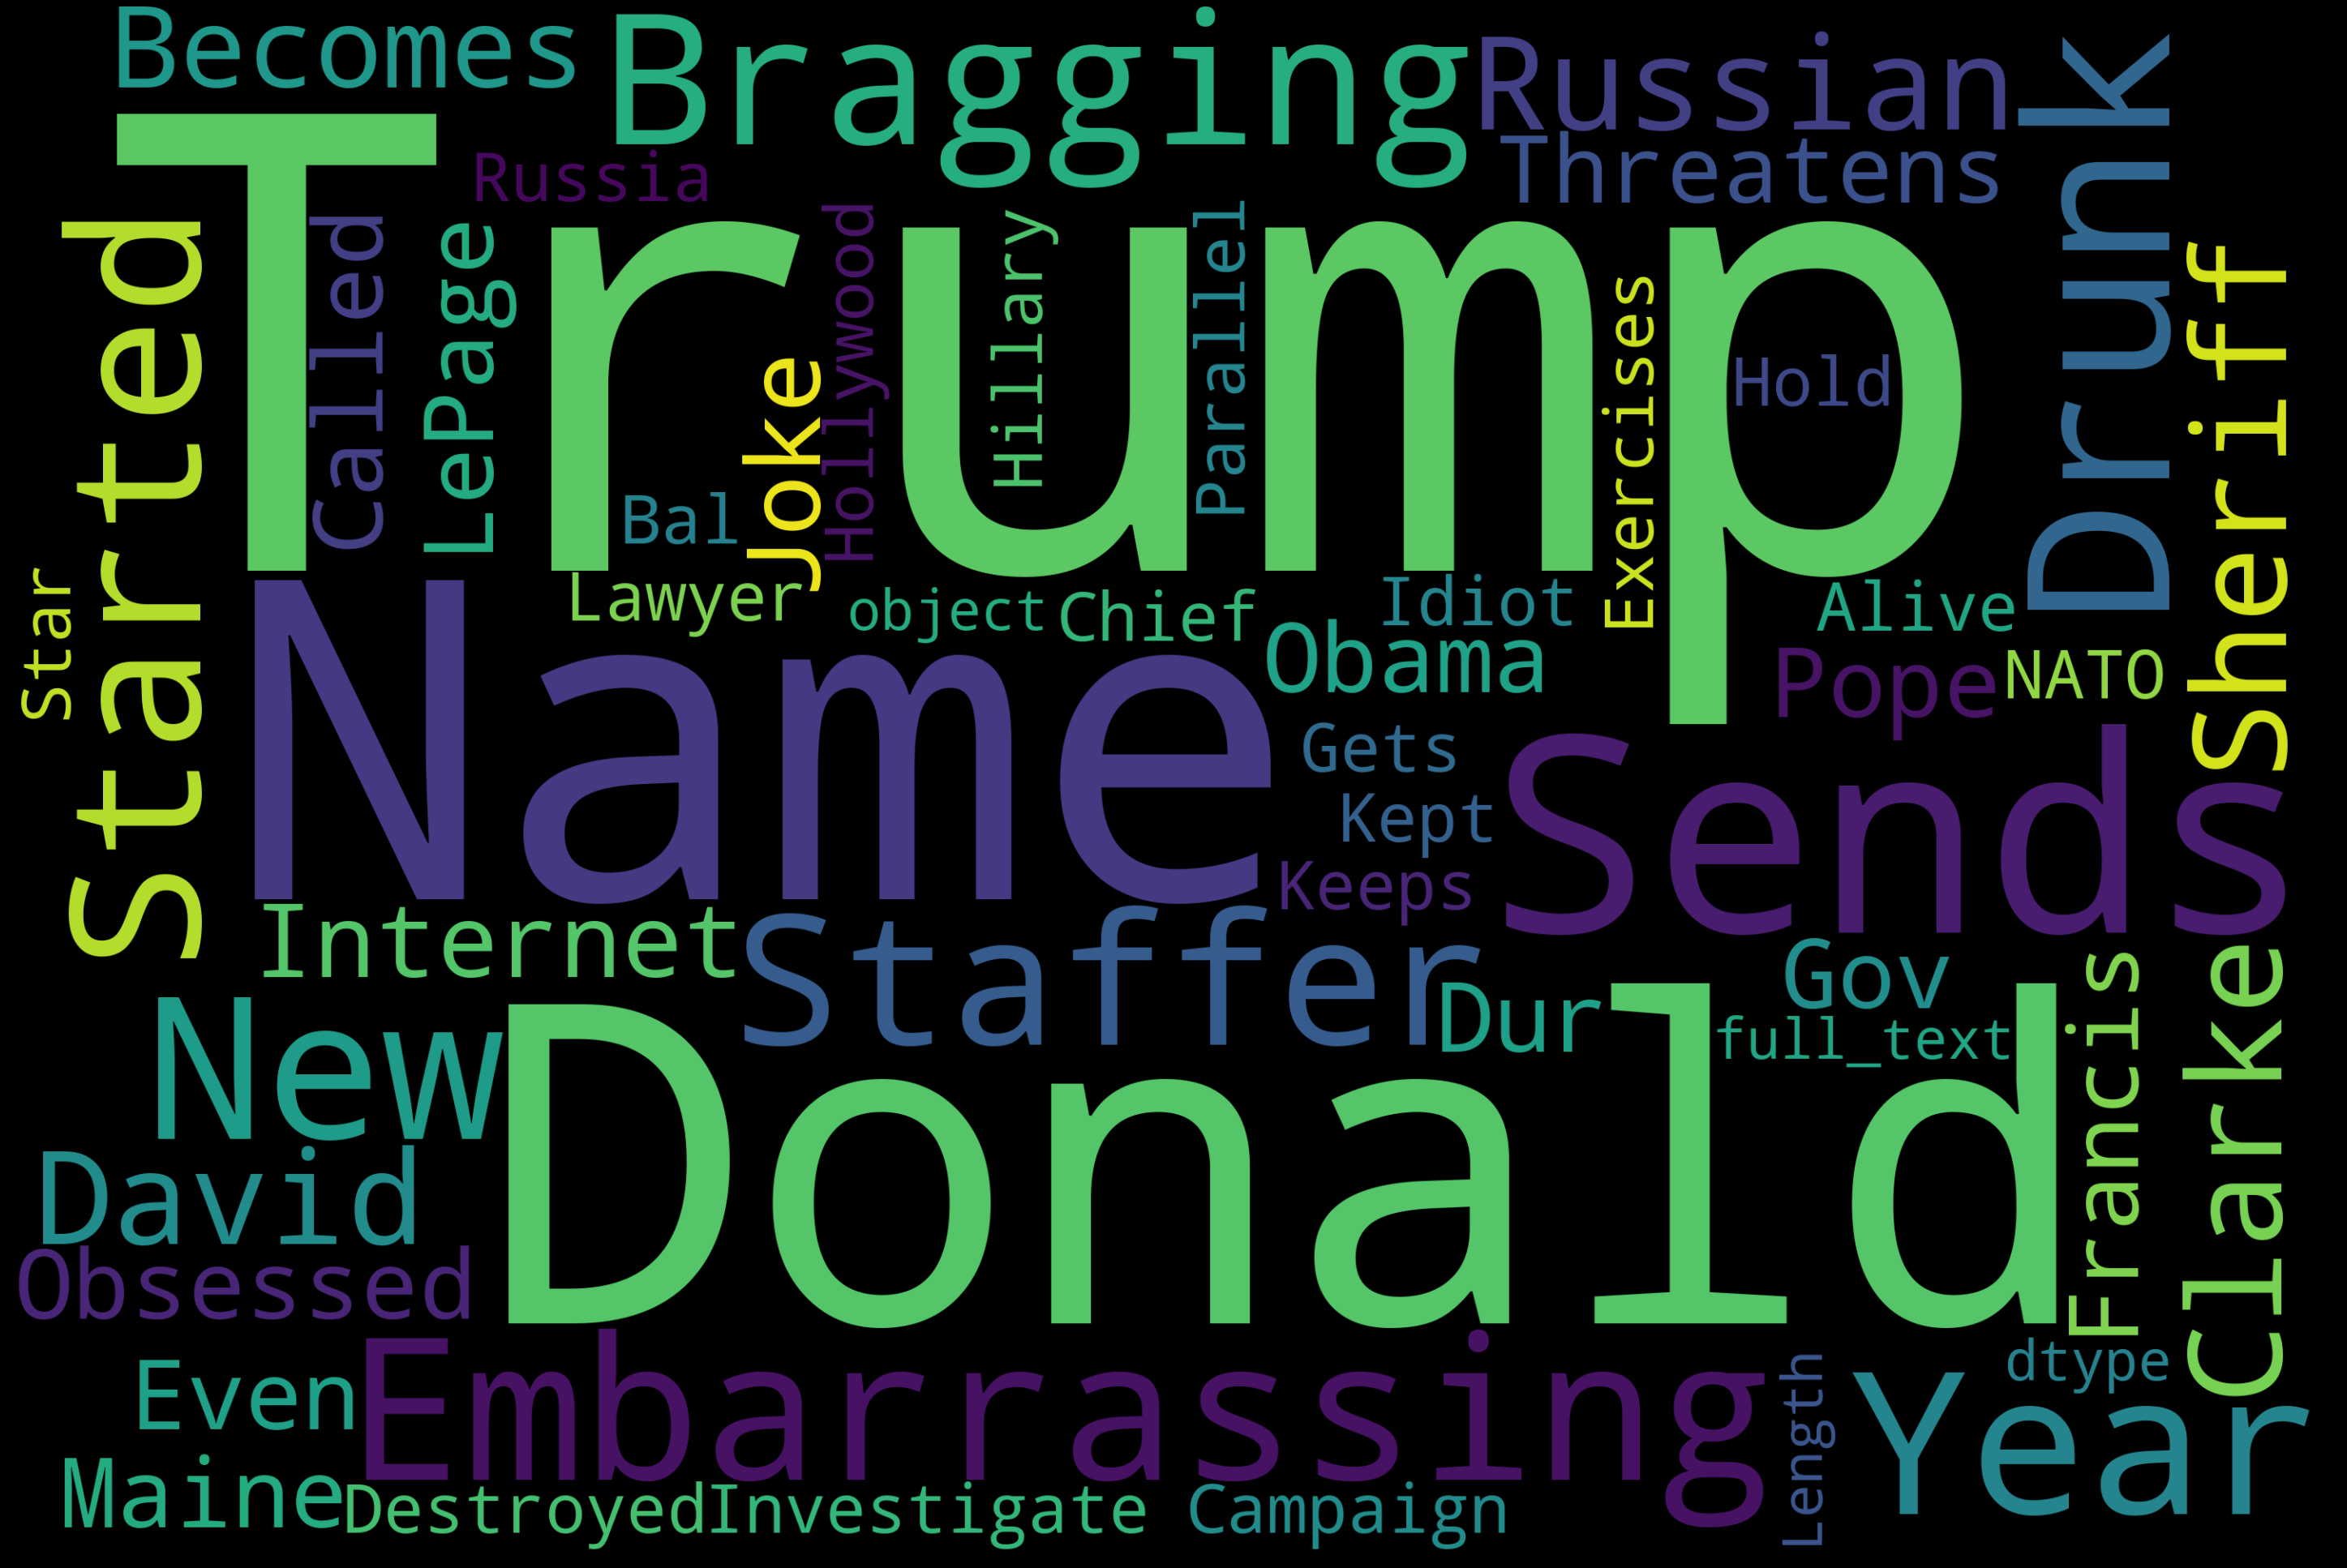

In [40]:
plot_wordcloud(fake["full_text"])
# plt.savefig("data/image/fake_wordcloud.png")

# Neural Networks with Keras

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = full_df.values
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(full_df["lemmatizing_text2"])
tfIdf

<65698x27892 sparse matrix of type '<class 'numpy.float64'>'
	with 605842 stored elements in Compressed Sparse Row format>

In [98]:
X = tfIdf
y = data[:, 0]

In [99]:
y = y.astype("int")

In [100]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# label_encoder.fit(y)
# encoded_y = label_encoder.transform(y)

In [101]:
# encoded_y, y

In [102]:
# from keras.utils import to_categorical

# # Step 2: One-hot encoding
# one_hot_y = to_categorical(encoded_y)
# one_hot_y

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [104]:
from tensorflow.keras.utils import to_categorical
# One-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_train_categorical

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [105]:
from tensorflow.keras.models import Sequential

model = Sequential()
from tensorflow.keras.layers import Dense
number_inputs = 27892
number_hidden_nodes = 4
model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
number_classes = 2
model.add(Dense(units=number_classes, activation='softmax'))

In [106]:
X_train.sort_indices()

In [107]:
X_test.sort_indices()

In [108]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 111572    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 10        
Total params: 111,582
Trainable params: 111,582
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
model.fit(
    X_train,
    y_train_categorical,
    epochs=10,
    shuffle=True,
    verbose=2
)

Epoch 1/10
1540/1540 - 2s - loss: 0.3678 - accuracy: 0.8813
Epoch 2/10
1540/1540 - 2s - loss: 0.1754 - accuracy: 0.9376
Epoch 3/10
1540/1540 - 2s - loss: 0.1332 - accuracy: 0.9524
Epoch 4/10
1540/1540 - 2s - loss: 0.1100 - accuracy: 0.9615
Epoch 5/10
1540/1540 - 2s - loss: 0.0941 - accuracy: 0.9675
Epoch 6/10
1540/1540 - 2s - loss: 0.0823 - accuracy: 0.9715
Epoch 7/10
1540/1540 - 2s - loss: 0.0733 - accuracy: 0.9758
Epoch 8/10
1540/1540 - 2s - loss: 0.0664 - accuracy: 0.9773
Epoch 9/10
1540/1540 - 2s - loss: 0.0606 - accuracy: 0.9800
Epoch 10/10
1540/1540 - 2s - loss: 0.0559 - accuracy: 0.9809


In [111]:
# Evaluate the model using the testing data
model_loss, model_accuracy = model.evaluate(
    X_test, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

514/514 - 0s - loss: 0.3015 - accuracy: 0.9074
Loss: 0.30148640275001526, Accuracy: 0.9073972702026367


In [ ]:
# model.save("netural_network.h5")

## testing

In [112]:
model.predict_classes(X_test[1])

array([1])

In [113]:
y_test

array([0, 1, 1, ..., 0, 0, 1])

In [116]:
X_test[1]

<1x27892 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [165]:
def findClass(new_data):
    wl = WordNetLemmatizer()
    stopwords= nltk.corpus.stopwords.words('english')
    words = re.split('\W+', new_data)
  # print(words)
    text = []
    for word in words:
        if word not in stopwords:
      # text = wl.lemmatize(word)
            text.append(wl.lemmatize(word))
    # new_text = ["".join(x) for x in text]
    new_text = [" ".join(text)]
    # print(new_text)
    # tfIdfVectorizer=TfidfVectorizer(use_idf=True)
    new_tfidf = tfIdfVectorizer.transform(new_text)
    # print(new_tfidf)
    new_tfidf.sort_indices()
    new_pred = model.predict_classes(new_tfidf)
    if new_pred[0] == 1:
        print("This is Fake!")
    else:
        print("This is True!")

    # return new_pred[0]

In [166]:
findClass(full_df['full_text'][2])

This is Fake!


In [155]:
full_df['label'][2]

1

In [168]:
val = "Super Bowl champ among latest wave of athletes accusing Michigan Wolverines' doctor of abuse"
findClass(val)

This is True!


In [156]:
true = true.reset_index()
fake = fake.reset_index()

In [157]:
test_total = 0
for i in range(len(true['full_text'])):
    if findClass(str(true['full_text'][i]))== 0:
        test_total += 1
    else:
        test_total += 0

print(test_total)

30344


In [158]:
test_total/len(true['full_text'])

0.9540938246761413

In [161]:
test_total_1 = 0
for i in range(len(fake['full_text'])):
    if findClass(str(fake['full_text'][i]))== 1:
        test_total_1 += 1
    else:
        test_total_1 += 0

print(test_total_1)

30344


In [162]:
print(test_total_1)

32587


In [163]:
test_total_1/len(fake['full_text'])

0.9614386027025432

# Deep Learning

In [169]:
deep_model = Sequential()
deep_model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
deep_model.add(Dense(units=number_hidden_nodes, activation='relu'))
number_classes = 2
deep_model.add(Dense(units=number_classes, activation='softmax'))

In [170]:
deep_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4)                 111572    
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 10        
Total params: 111,602
Trainable params: 111,602
Non-trainable params: 0
_________________________________________________________________


In [171]:
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(
    X_train,
    y_train_categorical,
    epochs=10,
    shuffle=True,
    verbose=2
)

Epoch 1/10
1540/1540 - 2s - loss: 0.3176 - accuracy: 0.8863
Epoch 2/10
1540/1540 - 2s - loss: 0.1486 - accuracy: 0.9451
Epoch 3/10
1540/1540 - 2s - loss: 0.1127 - accuracy: 0.9595
Epoch 4/10
1540/1540 - 2s - loss: 0.0912 - accuracy: 0.9679
Epoch 5/10
1540/1540 - 2s - loss: 0.0778 - accuracy: 0.9735
Epoch 6/10
1540/1540 - 2s - loss: 0.0679 - accuracy: 0.9766
Epoch 7/10
1540/1540 - 2s - loss: 0.0606 - accuracy: 0.9790
Epoch 8/10
1540/1540 - 2s - loss: 0.0551 - accuracy: 0.9805
Epoch 9/10
1540/1540 - 2s - loss: 0.0505 - accuracy: 0.9829
Epoch 10/10
1540/1540 - 2s - loss: 0.0467 - accuracy: 0.9843


In [172]:
deep_model_loss, deep_model_accuracy = deep_model.evaluate(
    X_test, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {deep_model_loss}, Accuracy: {deep_model_accuracy}")

514/514 - 0s - loss: 0.4009 - accuracy: 0.8978
Normal Neural Network - Loss: 0.400911808013916, Accuracy: 0.897777795791626


In [173]:
# deep_model.save("deep_model.h5")

### testing

In [180]:
def findClass_dl(new_data):
    wl = WordNetLemmatizer()
    stopwords= nltk.corpus.stopwords.words('english')
    words = re.split('\W+', new_data)
    text = []
    for word in words:
        if word not in stopwords:
      # text = wl.lemmatize(word)
            text.append(wl.lemmatize(word))
    new_text = [" ".join(text)]

    new_tfidf = tfIdfVectorizer.transform(new_text)
    new_tfidf.sort_indices()
    new_pred = deep_model.predict_classes(new_tfidf)
#     if new_pred[0] == 1:
#         print("This is Fake!")
#     else:
#         print("This is True!")

    return new_pred[0]

In [181]:
findClass_dl(full_df["full_text"][0])

1

In [182]:
test_total_2 = 0
for i in range(len(true['full_text'])):
    if findClass_dl(str(true['full_text'][i]))== 0:
        test_total_2 += 1
    else:
        test_total_2 += 0

print(test_total_2)

30007


In [183]:
test_total_2/len(true['full_text'])

0.943497673248648

In [184]:
test_total_3 = 0
for i in range(len(fake['full_text'])):
    if findClass_dl(str(fake['full_text'][i]))== 1:
        test_total_3 += 1
    else:
        test_total_3 += 0

print(test_total_3)

32620


In [185]:
test_total_3/len(fake['full_text'])

0.9624122263527468

# Naive Bayes

In [186]:
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, np.ravel(y_train))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [187]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
y_pred_nb = nb.predict(X_test)
print("Accuracy is:", metrics.accuracy_score(y_test, y_pred_nb))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_nb)))

Accuracy is: 0.8931506849315068
Mean Squared Error is: 0.32687813488897227


### Confusion Matrix

In [188]:
cm = metrics.confusion_matrix(y_test, y_pred_nb)
print(cm)

[[7110  899]
 [ 856 7560]]


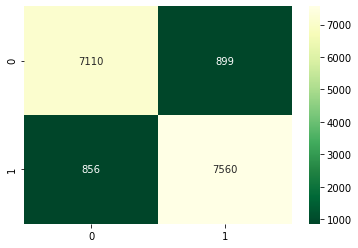

In [189]:
labels =  np.array([cm[0],cm[1]])
sns.heatmap(cm, annot=labels, fmt = '',cmap="YlGn_r")
plt.show()

In [190]:
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      8009
           1       0.89      0.90      0.90      8416

    accuracy                           0.89     16425
   macro avg       0.89      0.89      0.89     16425
weighted avg       0.89      0.89      0.89     16425



In [191]:
y_pred_prob = nb.predict_proba(X_test)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9594154295049248

# testing

In [192]:
nb.predict(X_test[2])

array([0])

In [193]:
y_test[2]

1

In [194]:
def findClass_nb(new_data):
    wl = WordNetLemmatizer()
    stopwords= nltk.corpus.stopwords.words('english')
    words = re.split('\W+', new_data)
    text = []
    for word in words:
        if word not in stopwords:
            text.append(wl.lemmatize(word))
            
    new_text = [" ".join(text)]

    new_tfidf = tfIdfVectorizer.transform(new_text)
    new_tfidf.sort_indices()
    new_pred = deep_model.predict_classes(new_tfidf)
#     if new_pred[0] == 1:
#         print("This is Fake!")
#     else:
#         print("This is True!")

    return new_pred[0]

In [196]:
text1 = "water is important"
findClass_nb(text1)

0

In [ ]:
full_df["label"][0]

1

In [197]:
test_total_4 = 0
for i in range(len(true['full_text'])):
    if findClass_nb(str(true['full_text'][i]))== 0:
        test_total_4 += 1
    else:
        test_total_4 += 0

print(test_total_4)

30007


In [198]:
test_total_4/len(true['full_text'])

0.943497673248648

In [199]:
test_total_5 = 0
for i in range(len(fake['full_text'])):
    if findClass_nb(str(fake['full_text'][i]))== 1:
        test_total_5 += 1
    else:
        test_total_5 += 0

print(test_total_5)

32620


In [200]:
test_total_5/len(fake['full_text'])

0.9624122263527468

# Logistic Regression

In [201]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [202]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [203]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.9404339090374039
Testing Data Score: 0.9201826484018265


In [204]:
y_pred_lr = classifier.predict(X_test)
print ("Accuracy is: ", metrics.accuracy_score(y_test, y_pred_lr))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Accuracy is:  0.9201826484018265
Mean Squared Error is: 0.2825196481630499


In [205]:
lr_cm = metrics.confusion_matrix(y_test, y_pred_lr)
print (lr_cm)

[[7282  727]
 [ 584 7832]]


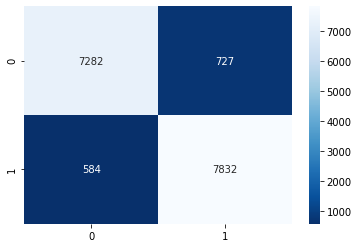

In [206]:
labels = np.array([lr_cm[0],lr_cm[1]])
sns.heatmap(lr_cm, annot=labels, fmt = '',cmap="Blues_r")
plt.show()

In [207]:
print(metrics.classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      8009
           1       0.92      0.93      0.92      8416

    accuracy                           0.92     16425
   macro avg       0.92      0.92      0.92     16425
weighted avg       0.92      0.92      0.92     16425



In [208]:
y_pred_prob_lr = classifier.predict_proba(X_test)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob_lr)

0.9743505494294205

### testing

In [209]:
def findClass_lr(new_data):
    wl = WordNetLemmatizer()
    stopwords= nltk.corpus.stopwords.words('english')
    words = re.split('\W+', new_data)
    text = []
    for word in words:
        if word not in stopwords:
            text.append(wl.lemmatize(word))
            
    new_text = [" ".join(text)]

    new_tfidf = tfIdfVectorizer.transform(new_text)
    new_tfidf.sort_indices()
    new_pred = deep_model.predict_classes(new_tfidf)
#     if new_pred[0] == 1:
#         print("This is Fake!")
#     else:
#         print("This is True!")

    return new_pred[0]

In [210]:
test_total_6 = 0
for i in range(len(true['full_text'])):
    if findClass_lr(str(true['full_text'][i]))== 0:
        test_total_6 += 1
    else:
        test_total_6 += 0

print(test_total_6)

30007


In [211]:
test_total_6/len(true['full_text'])

0.943497673248648

In [215]:
test_total_7 = 0
for i in range(len(fake['full_text'])):
    if findClass_lr(str(fake['full_text'][i]))== 1:
        test_total_7 += 1
    else:
        test_total_7 += 0

print(test_total_7)

32620


In [216]:
test_total_7/len(fake['full_text'])

0.9624122263527468

# Random Forest

In [217]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.920365296803653

In [218]:
y_pred_rf = rf.predict(X_test)
print ("Accuracy is: ", metrics.accuracy_score(y_test, y_pred_rf))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Accuracy is:  0.920365296803653
Mean Squared Error is: 0.2821962140007322


In [219]:
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf)
print (rf_cm)

[[7334  675]
 [ 633 7783]]


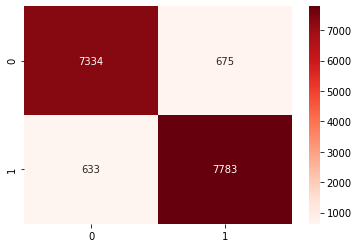

In [220]:
labels = np.array([rf_cm[0],rf_cm[1]])
sns.heatmap(rf_cm, annot=labels, fmt = '',cmap="Reds")
plt.show()

In [221]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      8009
           1       0.92      0.92      0.92      8416

    accuracy                           0.92     16425
   macro avg       0.92      0.92      0.92     16425
weighted avg       0.92      0.92      0.92     16425



In [222]:
y_pred_prob_rf = classifier.predict_proba(X_test)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob_rf)

0.9743505494294205